### Import packages

In [1]:
# data processing
import pandas as pd
import numpy as np

# modeling
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline

# plotting
import matplotlib.pyplot as plt
import seaborn as sns

### Set-up

In [13]:
infile = 'https://bitbucket.org/vishal_derive/vcu-data-mining/raw/3d740375d8d00c80e83dacbadc8b5e70cd2bfe48/data/credit_default_model_data.csv'

target = 'default payment next month'

### Read data

In [14]:
df = pd.read_csv(infile)

y = df[target]
X = df.drop(target, axis=1)

del df

In [15]:
X.head()

,LIMIT_BAL,AGE,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,...,pay_bucket_8_flag,pay_bucket_-2_flag,pay_bucket_-1_flag,pay_amt_total,bill_amt_total,pay_to_billed_ratio,zero_bill_amount,utilization_avg,utilization_max,group
0,40000,28,10371,11895,11228,2475,5341,6255,2567,0,...,0,0,1,11883,47565,0.249827,0,0.198187,0.297375,M
1,320000,35,12233,16490,20011,17918,18627,19167,7000,4100,...,0,0,0,15100,104446,0.144572,0,0.054399,0.062534,M
2,260000,35,188,188,188,188,194,188,188,188,...,0,0,1,1167,1134,1.029101,0,0.000727,0.000746,M
3,360000,36,308711,305594,306176,304645,315118,315782,11000,13000,...,0,0,0,71322,1856026,0.038427,0,0.859271,0.877172,M
4,500000,25,-46,9412,1260,0,1121,6566,9458,1260,...,0,0,1,20839,18313,1.137935,0,0.006104,0.018824,M


### Train-Test partition

In [16]:
X_train = X[X['group'] == 'M'].drop('group', axis=1)[X.columns[:-1]]
X_test = X[X['group'] == 'T'].drop('group', axis=1)[X.columns[:-1]]

y_train = y[X['group'] == 'M']
y_test = y[X['group'] == 'T']

len(X_train), len(X_test)

(15000, 7500)

### Logistic Regression model

In [17]:
logit = LogisticRegression(solver='lbfgs', max_iter=1000, random_state=314)

Standardize the input data.

In [33]:
X_scaler = StandardScaler()

# fit and transform the training data frame
X_train_std = X_scaler.fit_transform(X_train)

# transform the test data frame
X_test_std = X_scaler.transform(X_test)

Fit the model and get model scores.

In [19]:
logit.fit(X_train_std, y_train)

logit_scores_train = logit.predict_proba(X_train_std)[:, 1]
logit_scores_test = logit.predict_proba(X_test_std)[:, 1]

ROC Curve

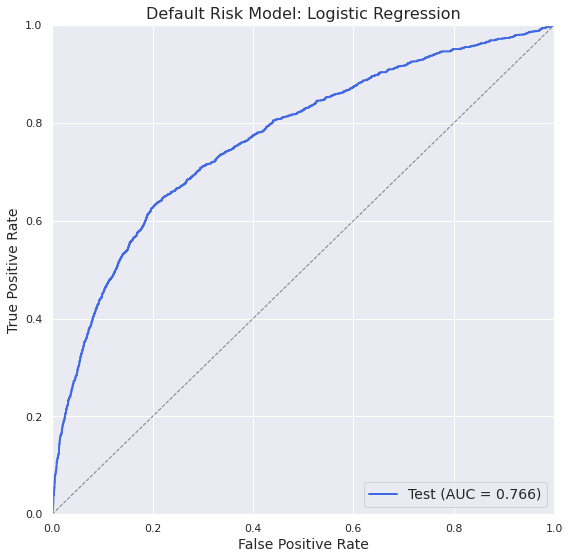

In [20]:
logit_fpr_test, logit_tpr_test, _ = roc_curve(y_test, logit_scores_test)
auc_logit = roc_auc_score(y_test, logit_scores_test)

sns.set(style='darkgrid')
plt.figure().set_size_inches(9, 9)

plt.plot(logit_fpr_test, logit_tpr_test, color='royalblue', lw=2, linestyle = '-',
         label=f'Test (AUC = {auc_logit:0.3f})')

plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate', fontsize = 14)
plt.ylabel('True Positive Rate', fontsize = 14)
plt.title('Default Risk Model: Logistic Regression', fontsize = 16)
plt.legend(loc="lower right", fontsize = 14);

### Principal Component Analysis (PCA)

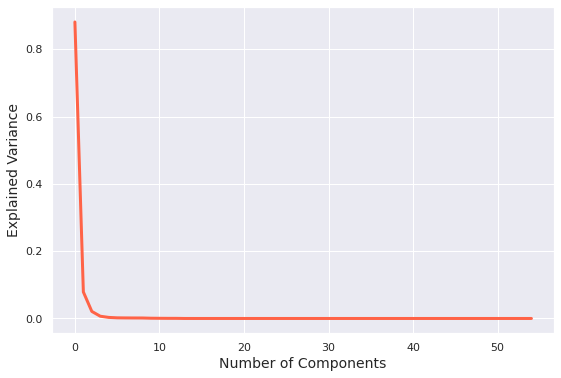

In [22]:
pca = PCA(random_state=314)
pca.fit(X_train)

n_cols = len(X_train.columns)

plt.figure().set_size_inches(9, 6)
sns.lineplot(x=range(n_cols), 
             y=pca.explained_variance_ratio_, 
             linewidth=3, 
             color='tomato')

plt.xlabel('Number of Components', fontsize = 14)
plt.ylabel('Explained Variance', fontsize = 14);

Cumulative Variance Explained

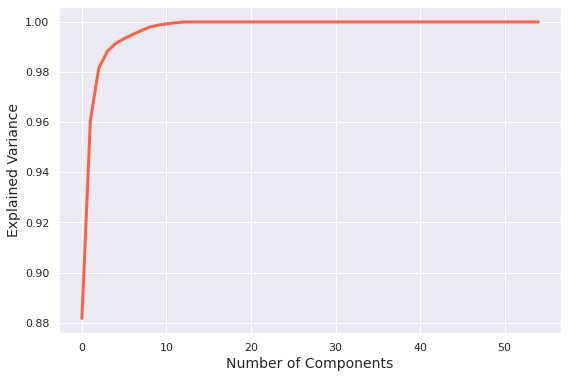

In [23]:
plt.figure().set_size_inches(9, 6)

sns.lineplot(x=range(n_cols), 
             y=np.cumsum(pca.explained_variance_ratio_), 
             linewidth=3, 
             color='tomato')

plt.xlabel('Number of Components', fontsize = 14)
plt.ylabel('Explained Variance', fontsize = 14);

A very few principal compoents appear to explain most of the variance in the data. The top ten principal components explain almost 100% of all variance!

We need to *standardize* the data before fitting PCA -- or, run PCA on the standardized data.

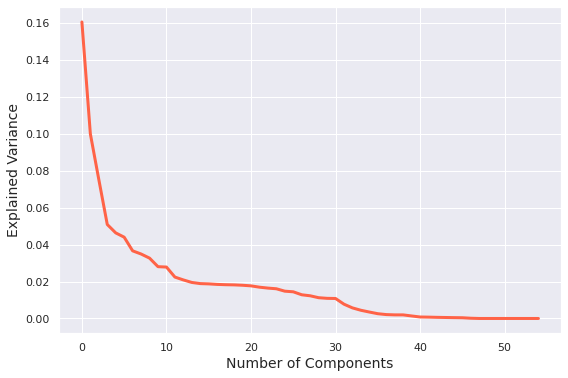

In [24]:
pca.fit(X_train_std)

plt.figure().set_size_inches(9, 6)

sns.lineplot(x=range(n_cols), 
             y=pca.explained_variance_ratio_, 
             linewidth=3, 
             color='tomato')

plt.xlabel('Number of Components', fontsize = 14)
plt.ylabel('Explained Variance', fontsize = 14);

Cumulative Variance Explained

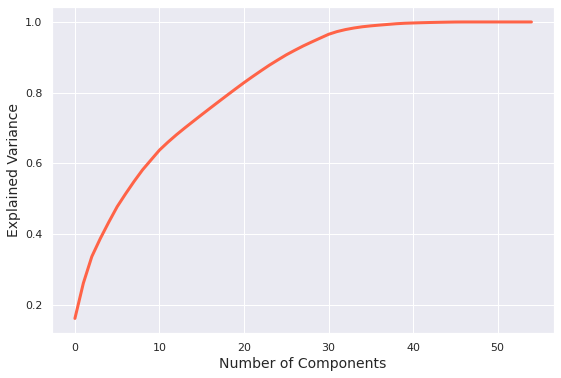

In [26]:
plt.figure().set_size_inches(9, 6)

sns.lineplot(x=range(n_cols), 
             y=np.cumsum(pca.explained_variance_ratio_),
             linewidth=3, 
             color='tomato')

plt.xlabel('Number of Components', fontsize = 14)
plt.ylabel('Explained Variance', fontsize = 14);

In [27]:
np.cumsum(pca.explained_variance_ratio_)[30]

0.9650021896711285

Let's keep the top 30 principal compoents. By doing so, we will retain 97% of the total variance.

In [28]:
components_to_keep = 30

pca = PCA(n_components=components_to_keep, random_state=314)

### Pipelines

In [34]:
# define the pipeline
pl = Pipeline(steps=[('scaling', X_scaler),
                     ('pca', pca),
                     ('logit', logit)])

# fit the pipeline
pl_fit = pl.fit(X_train, y_train)

# calculate model scores (predicted probabilities)
pl_scores_test = pl_fit.predict_proba(X_test)[:, 1]

ROC Curve

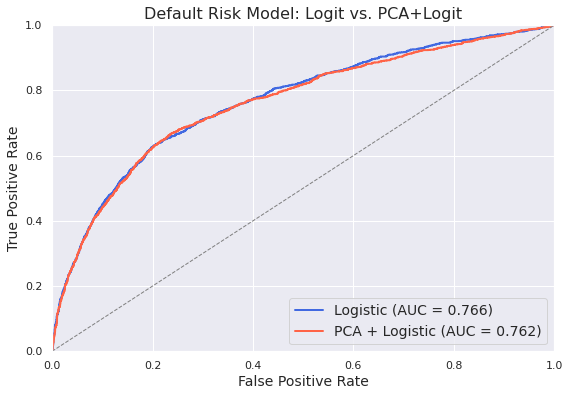

In [30]:
pl_fpr_test, pl_tpr_test, _ = roc_curve(y_test, pl_scores_test)
auc_pl = roc_auc_score(y_test, pl_scores_test)

plt.figure().set_size_inches(9, 6)

plt.plot(logit_fpr_test, logit_tpr_test, color='royalblue', lw=2, label=f'Logistic (AUC = {auc_logit:0.3f})')

plt.plot(pl_fpr_test, pl_tpr_test, color='tomato', lw=2, label=f'PCA + Logistic (AUC = {auc_pl:0.3f})')

plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate', fontsize = 14)
plt.ylabel('True Positive Rate', fontsize = 14)
plt.title('Default Risk Model: Logit vs. PCA+Logit', fontsize = 16)
plt.legend(loc="lower right", fontsize = 14);

Why did the performance of the model didn't improve?

What would happen if we keep *all* principal components?

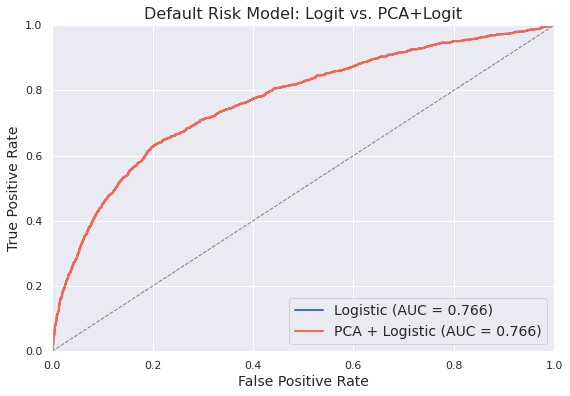

In [31]:
pca = PCA(random_state=314)

# define the pipeline
pl = Pipeline(steps=[('scaling', X_scaler),
                     ('pca', pca),
                     ('logit', logit)])

# fit the pipeline
pl_fit = pl.fit(X_train.astype(float), y_train)

# calculate model scores (predicted probabilities)
pl_scores_test = pl_fit.predict_proba(X_test.astype(float))[:, 1]

# ROC Curve
pl_fpr_test, pl_tpr_test, _ = roc_curve(y_test, pl_scores_test)
auc_pl = roc_auc_score(y_test, pl_scores_test)

plt.figure().set_size_inches(9, 6)

plt.plot(logit_fpr_test, logit_tpr_test, color='royalblue', lw=2, label=f'Logistic (AUC = {auc_logit:0.3f})')

plt.plot(pl_fpr_test, pl_tpr_test, color='tomato', lw=2, label=f'PCA + Logistic (AUC = {auc_pl:0.3f})')

plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate', fontsize = 14)
plt.ylabel('True Positive Rate', fontsize = 14)
plt.title('Default Risk Model: Logit vs. PCA+Logit', fontsize = 16)
plt.legend(loc="lower right", fontsize = 14);